In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
import os
import tensorflow as tf
import numpy as np

SEED = 1200
tf.random.set_seed(SEED)

In [ ]:
# Run this cell only if you are using Colab with Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Run this cell only if you are using Colab with Drive

!unzip '/content/drive/My Drive/ANN_Projects/artificial-neural-networks-and-deep-learning'

In [ ]:
!ls '/content/MaskDataset'


test  train_gt.json  training


In [ ]:
import pandas as pd
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset_dir = '/content/MaskDataset'
with open(os.path.join(dataset_dir,'train_gt.json')) as f: train_gt = json.load(f)

dataframe = pd.DataFrame(train_gt.items())
dataframe.rename(columns = {0:'filename', 1:'class'}, inplace = True)
dataframe['class'] = dataframe['class'].astype(str)

# Batch size
bs = 10

# Img shape
img_h = 512
img_w = 512

# Class numbers
num_classes = 3

# Fraction of images reserved for validation
validation_split = 0.15

# Data generator
data_gen = ImageDataGenerator(rescale=1./255,
                              validation_split=validation_split)

# Training directory
training_dir = os.path.join(dataset_dir, 'training')

train_gen = data_gen.flow_from_dataframe(dataframe,
                                         training_dir,
                                         batch_size=bs,
                                         target_size=(img_h, img_w),
                                         class_mode='categorical',
                                         shuffle=True,
                                         seed=SEED,
                                         subset='training')

valid_gen = data_gen.flow_from_dataframe(dataframe,
                                         training_dir,
                                         batch_size=bs,
                                         target_size=(img_h, img_w),
                                         class_mode='categorical',
                                         shuffle=True,
                                         seed=SEED,
                                         subset='validation')
# Training
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))
train_dataset = train_dataset.repeat()

# Validation
valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))
valid_dataset = valid_dataset.repeat()


Found 4772 validated image filenames belonging to 3 classes.
Found 842 validated image filenames belonging to 3 classes.


[]

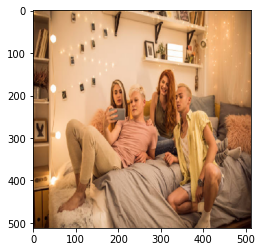

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

iterator = iter(valid_dataset)

augmented_img, target = next(iterator)
augmented_img = np.array(augmented_img[0])
augmented_img = augmented_img * 255

plt.imshow(np.uint8(augmented_img))
plt.plot()

In [ ]:
# CNN Architecture

model = tf.keras.Sequential()

# Features extraction

model.add(tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding='same', input_shape=[img_h, img_w, 3]))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

# Classifier
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=16, activation='relu'))
model.add(tf.keras.layers.Dense(units=8, activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 8)       224       
_________________________________________________________________
re_lu (ReLU)                 (None, 512, 512, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 16)      1168      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 256, 256, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      4

In [ ]:
# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# Learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Validation metrics
metrics = ['accuracy']

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
import os
from datetime import datetime

project_dir = '/content/drive/My Drive/ANN_Projects'

exps_dir = os.path.join(project_dir, 'classification_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'
exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)

callbacks = []

# Model Checkpoint
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'),
                                                   save_weights_only=True)
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)
callbacks.append(tb_callback)

# Early Stopping
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=10,
                                                   restore_best_weights=True)
    callbacks.append(es_callback)

ckpt_dir

In [ ]:
#model.load_weights('/content/drive/My Drive/ANN_Projects/classification_experiments/cp_13.ckpt')

model.fit(x=train_dataset,
          epochs=100,
          steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen),
          callbacks=callbacks)

Epoch 1/100
478/478 [==============================] - 64s 135ms/step - loss: 1.0667 - accuracy: 0.3841 - val_loss: 1.6012 - val_accuracy: 0.0000e+00
Epoch 2/100
478/478 [==============================] - 64s 135ms/step - loss: 1.0492 - accuracy: 0.3971 - val_loss: 1.3311 - val_accuracy: 0.0000e+00
Epoch 3/100
478/478 [==============================] - 64s 135ms/step - loss: 1.0163 - accuracy: 0.4189 - val_loss: 1.1701 - val_accuracy: 0.0000e+00
Epoch 4/100
478/478 [==============================] - 65s 135ms/step - loss: 0.8520 - accuracy: 0.5897 - val_loss: 0.9170 - val_accuracy: 0.9133
Epoch 5/100
478/478 [==============================] - 65s 135ms/step - loss: 0.7283 - accuracy: 0.6846 - val_loss: 0.8361 - val_accuracy: 0.8527
Epoch 6/100
478/478 [==============================] - 65s 136ms/step - loss: 0.6692 - accuracy: 0.7091 - val_loss: 0.5205 - val_accuracy: 0.9893
Epoch 7/100
478/478 [==============================] - 65s 135ms/step - loss: 0.6107 - accuracy: 0.7418 - val_lo

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/My\ Drive/ANN_Projects/classification_experiments/

In [ ]:
def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [ ]:
from PIL import Image
import ntpath

test_dir = os.path.join(dataset_dir, 'test')
image_filenames = next(os.walk(test_dir))[2]
images = pd.DataFrame(image_filenames)

images.rename(columns = {0:'filename'}, inplace = True)
images['class'] = 'test'

# Create a data generator for the test images
test_gen = data_gen.flow_from_dataframe(images,
                                        test_dir,
                                        batch_size=bs,
                                        target_size=(img_h, img_w),
                                        class_mode='categorical',
                                        shuffle=False,
                                        seed=SEED)

test_gen.reset()

# Predict the classes for the test images
predictions = model.predict_generator(test_gen, len(test_gen), verbose=1)

results = {}
images = test_gen.filenames
i = 0

for p in predictions:
  prediction = np.argmax(p)
  image_name = ntpath.basename(images[i])
  results[image_name] = str(prediction)
  i = i + 1

create_csv(results,'/content/drive/My Drive/ANN_Projects/')